Author: Abdulrahman Altahhan, Jan 2023.

The notebook use a library of functionality in RL that aims for simplicity and general insight into how algorithms work, these libraries are written from scratch using standard python libraries (numpy, matplotlib etc.).
Please note that you will need to take a permission from the author to use the code for research, commercially or otherwise.

# Lesson 4-Tabular Methods: Monte Carlo

**Learning outcomes**
1. understand the difference between learning the expected return and computing it via dynamic programming
1. understand the strengths and weaknesses of MC methods
1. appreciating that MC methods need to wait till the end of the task to obtain its estimate of the expected return
1. compare MC methods with dynamic programming methods
1. understand the implication of satisfying and not satisfying the explore-start requirement for the MC control and how to mitigate it via the reward function
1. understand how to move from prediction to control by extending the V function to a Q function and make use of the idea of generalised policy iteration-GPI
1. understand how policy gradient methods work and appreciate how they differ from value function methods


**Reading**:
The accompanying reading of this lesson is **chapter 5** from our textbook by Sutton and Barto available online [here](http://incompleteideas.net/book/RLbook2020.pdf). Please note that we explain the ideas of this topic from a practical perspective and not from a theoretical perspective, which is already covered in the textbook. Please note that off-policy methods are not covered and hence can be skipped safely when reading from the textbook.


In this lesson, we develop the ideas of Monte Carlo methods. Monte Carlo methods are powerful and widely used in settings other than RL. You may have encountered them in a previous module where they were mainly used for sampling. We will also use them here to sample observations and average their expected returns. Because they average the returns, Monte Carlo methods have to wait until *all* trajectories are available to estimate the return. Later, we will find out that Temporal Difference methods do not wait until the end of the episode to update their estimate and outperform MC methods.

Note that we have now moved to *learning* instead of *computing* the value function and its associated policy. This is because we expect our agent to learn from *interacting with the environment* instead of using the dynamics of the environment, which is usually hard to compute except for a simple lab-confined environment. 

Remember that we are dealing with *expected return*, and we are either finding an *exact solution for this expected return* as when we solve the set of Bellman equations or finding an *approximate solution for the expected return* as in DP or MC.
Remember also that the expected return for a state is the future cumulative discounted rewards given that the agent follows a specific policy.

One pivotal observation that summarises the justification for using MC methods over DP methods is that it is often the case that we are able to interact with the environment instead of obtaining its dynamics due to tractability issues.

## Plan

As usual, in general, there are two types of RL problems that we will attempt to design methods to deal with 
1. Prediction problem
For These problems, we will design Policy Evaluation Methods that attempt to find the best estimate for the value function given a policy.


2. Control problems 
For These problems, we will design Value Iteration methods that utilise Generalised Policy Iteration. They attempt to find the best policy by estimating an action-value function for a current policy and then moving to a better and improved one by often choosing a greedy action. They minimise an error function to improve their value function estimate, used to deduce a policy.
We will then move to Policy Gradient methods that directly estimate a useful policy for the agent by maximising its value function.


We start by assuming that the policy is fixed. This will help us develop an algorithm that predicts the state space's value function (expected return). Then we will move to the policy improvement methods, i.e. these methods that help us to compare and improve our policy with respect to other policies and move to a better policy when necessary. Then we move to the control case (policy iteration methods).

## First visit MC Policy-evaluation (prediction) 
Value-function approximation Method

Because MC methods depend entirely on experience, a natural way to approximate the cumulative future discounted reward is by taking their average once they become available through experience. So we must collect the cumulative *future* discounted reward once this experience has elapsed. In other words, we need to take the sum *after* the agent has finished an episode for all the rewards obtained from the current state to the end of the episode. Then we average those returns over all of the available episodes. 

Note that MC methods only apply for episodic tasks, which is one of its limitations in addition to having to wait until the episode is finished.

Note also that the agent can visit the same state more than once inside the same episode. We can take the sum starting from the first visit, or every visit, each yields a different algorithm. The first-visit algorithm is more suitable for tabular methods, while the every-visit algorithm is more suitable when using function approximation methods (such as neural networks).

## MRP environment for prediction

To be able to develop the methods of MC we would need to develop an MRP and MDP classes that is able to interact and collect experience from an environment for prediction and control, respectively. Below we show the skeleton of this class.

In [1]:
%matplotlib inline

In [2]:
import nbimporter
from Lesson3_DynamicProgramming import * # this also import subsequently from Lesson2_GridWorldMDPs

### Comparing speed for random number generation.
Before we get started, it is useful to study our options for random number generation. We will be using random number generation intensively when we sample. Below we show how each function will take to perform 10^6 random number generation for 2 actions.

In [3]:
Qs = np.ones(4)
Qs[1] = 2
Qs[3] = 2

choice(np.where(Qs==Qs.max())[0]) # choices(Qs==Qs.max(), k=1)

1

In [4]:
np.array(sample(range(1000), k=32))

array([490, 965, 101, 306, 515, 985, 432, 659, 721, 180, 629,  40, 932,
       960, 127, 275, 893, 650, 339, 320, 449, 587, 479, 964, 626, 329,
       897, 205, 713, 334, 547, 861])

In [5]:
np.random.choice(1000, 32, replace=False)

array([718, 880, 924, 844, 230, 827, 360, 560, 470, 543, 773, 344, 143,
       748,   8, 775, 913, 484, 181, 670, 309, 604, 761, 583, 321, 846,
       279, 949, 426, 269, 464, 124])

In [6]:
n=int(1e5)
print('with replacement')
%time for _ in range(n): choices(np.where(Qs==Qs.max())[0])[0]
%time for _ in range(n): choice (np.where(Qs==Qs.max())[0])
print()

# sampling without replacement
print('without replacement')
%time for _ in range(n): sample(range(10000), k=32)
%time for _ in range(n): np.random.choice(10000, 32, replace=False)
print()

# when we have a binary choice (such as when use ε-greedy) 
print('binary choices')
%time for _ in range(n): np.random.randint(0,1)
%time for _ in range(n): np.random.binomial(1, p=0.5)

with replacement
Wall time: 547 ms
Wall time: 1.63 s

without replacement
Wall time: 1.82 s
Wall time: 18.5 s

binary choices
Wall time: 204 ms
Wall time: 183 ms


As we can see, the *choice**s**()* function is far more efficient. However, this is part of the story because the quality of the random number generation of these functions varies significantly. Usually, the more it takes, the better distribution it maintains. To that end, the binomial distribution seems to give a sweet spot for generating two actions, which is far more efficient than *choice()*, both of which are from numpy. However, the binomial is good for two actions only. If we want to deal with more actions, we can use np.random.multinomial, but it is less efficient than binomial. The choice**s**() function is the most efficient, but it has less quality which we compensate for by running more experiments (to eliminate the bias), while choice() is the least efficient of all of these functions. With that in mind, we develop the infrastructure for our RL algorithms. Of course, when we use random number generation, we need to use the seed() function to repeat a set of experiments consistently. The call will depend on the library that we use:

In [7]:
random.seed(0)
np.random.seed(0)

### MRP Class for prediction
In the following class, we will try to build a useful and generic MDP/MRP class that will serve our different needs in various RL coverage steps. In particular, we want the interact() and the steps() functions to be as flexible and generic as possible. Towards that end, we have constructed our class to have the following sections:

1. Initialisation part: initialises the different variables necessary for our treatment
2. Buffer storage section: store experience
3. Steps section: takes a step in the environment and stores its correspondent dynamic (r,s,a). We have two types of steps: step_a(), suitable for most algorithms, and step_an(), which requires knowing the next action in advance. These two are useful in unifying the treatment of different RL algorithms, including prediction and control. For example, TD (prediction) and Q-learning(control) have a similar algorithm structure that entails using step_a(), while the Sarsa algorithm (control) uses step_an(). You will see these algorithms in the next lesson. Just be aware that you might want to change the default step function, step_a(), if your algorithm needs to know the next action, designated as *an*, to update its value function estimation.
4. Interact section: this part is the heart and soul of our class. It runs several episodes, each with several steps, until a goal is reached, a buffer is full, or some other condition is met.
5. Policy section: this is a set of policies according to which the agent will act. They can be either stationary (i.e., their probabilities do not change) or non-stationary (i.e., their probability will vary with Q, our action-value-function estimation).
6. Metric section: to measure the performance of our algorithms. Basically, we use three metrics: 
- the number of steps an agent took to reach a goal
- the sum of rewards an agent collected during an episode
- the root mean squared error of the value function estimation and the true values of an MDP or MTRP problem. This metric implies that we know a solution for a prediction in advance.
7. Visualisation functions can be overridden in children's classes as per our needs.


In [8]:
Rs = [1,2,3,4,5,6,7,8,9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
ep = 20
Rs[max(0,ep-10):ep]

[11, 12, 13, 14, 15, 16, 17, 18, 19, 20]

In [9]:
class MRP:
    
    def __init__(self, env=randwalk(), γ=1, α=.1, v0=0, episodes=100, view=1, 
                 store=False, # Majority of methods are pure one-step online and no need to store episodes trajectories 
                 max_t=2000, seed=None, visual=False, underhood='', 
                 last=10, print_=False):
                

        # hyper parameters
        self.env = env
        self.γ = γ
        self.α = α # average methods(like MC1st) do not need this but many other methods (like MCα) do
        self.v0 = v0
        self.episodes = episodes
        self.store = store
        self.max_t = max_t
        self.visual = visual
        self.view = view
        self.underhood = underhood
        self.last = last
        self.print = print_
        
        # reference to two important functions
        self.policy = self.stationary
        self.step = self.step_a
        # we might want to skip a step
        self.skipstep = False
        
        nA = self.env.nA
        self.As = list(range(nA))
        self.pAs = [1/nA]*nA
        
        # useful to repeate the same experiement
        self.seed(seed)
        # to protect interact() in case of no training 
        self.ep = -1 
        
    # set up important metrics
    def init_metrics(self):
        self.Ts = np.zeros(self.episodes, dtype=np.uint32)
        self.Rs = np.zeros(self.episodes)
        self.Es = np.zeros(self.episodes)  
        self.inds = np.ones (self.episodes, dtype=bool)
        
    # set up the V table
    def init_(self):
        self.V = np.ones(self.env.nS)*self.v0

    
    # useful for inheritance, gives an expected return (value) for state s
    def V_(self, s=None): 
        return self.V  if s is None else self.V[s]
    
    def seed(self, seed=None, **kw):
        if seed is not None: np.random.seed(seed); random.seed(seed)
    #-------------------------------------------buffer related-------------------------------------------------
    # The buffer get reinitialised by reinitialising t only but we have to be careful not to exceed t+1 at any time
    def allocate(self): 
        if not self.store: return
        self.r = np.zeros(self.max_t)
        self.s = np.ones(self.max_t, dtype=np.uint32)*(self.env.nS+10) # states are indices:*(nS+10)for debugging 
        self.a = np.ones(self.max_t, dtype=np.uint32)*(self.env.nA+10) #actions are indices:*(nA+10)for debugging       
        self.done = np.zeros(self.max_t, dtype=bool)
    
    def store_(self, s=None,a=None,rn=None,sn=None,an=None, done=None, t=0):
        if not self.store: return
        
        if s  is not None: self.s[t] = s
        if a  is not None: self.a[t] = a
        if rn is not None: self.r[t+1] = rn
        if sn is not None: self.s[t+1] = sn
        if an is not None: self.a[t+1] = an
        if done is not None: self.done[t+1] = done
    
    def stop_ep(self, done):
        return done or (self.store and self.t+1 >= self.max_t-1) # goal reached or storage is full
    
    # ------------------------------------ experiments related --------------------------------------------
    def stop_exp(self):
        if self.stop_early(): print('experience stopped at episode %d'%self.ep); return True
        return self.ep == self.episodes - 1

    #----------------------------------- 🐾steps as per the algorithm style --------------------------------
    def step_0(self):
        s = self.env.reset()                                 # set env/agent to the start position
        a = self.policy(s)
        return s,a
    
    # accomodates Q-learning and V style algorithms
    def step_a(self, s,_, t):                          
        if self.skipstep: return 0, None, None, None, True
        a = self.policy(s)
        sn, rn, done, _ = self.env.step(a)
        
        # we added s=s for compatibility with deep learning
        self.store_(s=s, a=a, rn=rn, sn=sn, done=done, t=t)
        
        # None is returned for compatibility with other algorithms
        return rn,sn, a,None, done
    
    # accomodates Sarsa style algorithms
    def step_an(self, s,a, t):                          
        if self.skipstep: return 0, None, None, None, True
        sn, rn, done, _ = self.env.step(a)
        an = self.policy(sn)
        
        # we added s=s for compatibility with deep learning later
        self.store_(s=s, a=a, rn=rn, sn=sn, an=an, done=done, t=t)
        return rn,sn, a,an, done
    
    #------------------------------------ 🌖 online learning and interaction --------------------------------
    def interact(self, train=True, grid_img=False, **kw):
        if train:
            self.init_()
            self.init()                                     # user defined init() before all episodes
            self.init_metrics()
            self.allocate()
            self.plot0()                                    # useful to see initial V values
            self.seed(**kw)
            self.ep = -1 #+ (not train)*(self.episodes-1)
            self.t_ = 0                                     # steps counter for all episodes
        
        #for self.ep in range(self.episodes):
        while not self.stop_exp():
            self.ep += 1
            self.t  = -1                                    # steps counter for curr episode
            self.Σr = 0
            done = False
            #print(self.ep)
            # initial step
            s,a = self.step_0()
            self.step0()                                    # user defined init of each episode
            # an episode is a set of steps, interact and learn from experience, online or offline.
            while not self.stop_ep(done):
                #print(self.t_)
                
                # take one step
                self.t += 1
                self.t_+= 1
                
                rn,sn, a,an, done = self.step(s,a, self.t)  # takes a step in env and store tarjectory if needed
                self.online(s, rn,sn, done, a,an) # to learn online, pass a one step trajectory
                
                self.Σr += rn
                self.rn = rn
                s,a = sn,an
                
                # render last view episodes, for games ep might>episodes
                if self.visual and self.episodes > self.ep >= self.episodes-self.view: self.render(**kw)

            # to learn offline and plot episode
            self.metrics()
            self.offline()
            self.plot_ep()
            
    
        # plot experience   
        self.plot_exp(**kw)
        
        return self  
    #------------------------------------- policies types 🧠-----------------------------------
        
    def stationary(self, *args):
        #return choice(self.As, 1, p=self.pAs)[0] # this gives better experiements quality but is less efficient
        return choices(self.As, weights=self.pAs, k=1)[0] if self.env.nA!=2 else np.random.binomial(1, 0.5)
    
    #---------------------------------------perfromance metrics📏 ------------------------------
    def metrics(self):
        # we use %self.episodes so that when we use a different criterion to stop_exp() code will run
        self.Ts[self.ep%self.episodes] = self.t+1
        self.Rs[self.ep%self.episodes] = self.Σr
        self.Es[self.ep%self.episodes] = self.Error()
        
        if self.print: print(self)
    
    def __str__(self):
        # mean works regardless of where we stored the episode metrics (we use %self.episodes)
        ep, episodes = self.ep, self.episodes
        i, inds = ep%episodes, self.inds.copy()
        last = min(ep+1, self.last) # display last 10 episodes or so
        inds[i+1: episodes+1-(last-i)] = False # turn off indexes that we do not want, to deal with circular indexes
        
        metrics = 'step %d, episode %d, r %.2f, mean r last %d ep %.2f, ε %.2f'
        values = (self.t_, ep, self.Rs[i], last, self.Rs[inds][-last:].mean().round(2), round(self.ε, 2))

        return metrics%values

    #------------------------functions that can be overridden in the child class-----------------
    def init(self):
        pass
    def step0(self):
        pass
    def Error(self):
        return 0
    def stop_early(self):
        return False
    def plot0(self):
        pass
    def plot_t(self):
        pass
    def plot_ep(self):
        pass
    def plot_exp(self, *args):
        pass
    def offline(self):
        pass
    def online(self,*args):
        pass
    #---------------------------------------visualise ✍️----------------------------------------
    # overload the env render function
    def render(self, rn=None, label='', **kw):
        if rn is None: rn=self.rn
        param = {'V':self.V_()} if self.underhood=='V' else {}
        self.env.render(**param, 
                        label=label+' reward=%d, t=%d, ep=%d'%(rn, self.t+1, self.ep+1), 
                        underhood=self.underhood, 
                        **kw)


In [10]:
episodes = 11
sz = 5

ep = 71
a = np.array(range(episodes))+10
i = ep%episodes
print(i)
# print(a[i-5+1:i+1])
ind = np.ones(episodes, dtype=bool)
ind[i+1:episodes+1-(sz-i)]=0


print(a[ind][-sz:])

5
[11 12 13 14 15]


As we can see, we defined a form of Markov Decision Process-MDP called Markov Reward Process-MRP. Like an MDP, an MRP is a stochastic process that concentrates on the rewards and states only and neutralizes the effect of actions. It is useful to study the predictive capabilities of an RL method where there are no decisions(actions) to be taken, and only we try to guess(predict) the returns of a process. 

Whenever there is a predictive algorithm, we will use **MRP**, while when we develop a control algorithm, we will use **MDP**. 

A typical example of an MRP is a random walk process, where an agent randomly moves left or right in a straight line of cells. A terminal state is at the end of each direction (left and right). The agent can be rewarded differently in each cell. Often, we reward the agent for moving to the far-right terminal state by 1 and everywhere else with 0. Another type of reward is to give the agent a negative -1 penalty on the far-left terminal state and 1 on the far-right state, and 0 everywhere else. See page 125 of the book.

Note that the only assumption about the environment is to provide a reset() and a step() functions that abide by the following general form:
1. reset() must return a value of the initial state with a proper representation. So, when we move to function approximation, it must return a vector representing the state.
2. step() must return four values,  the first is the state (observation) that is compatible with what is returned by reset(). The second is the reward for the current state, and the third is a flag to signal the end of an episode; usually, when the agent achieves the required task or fails for some reason, each would have a corresponding suitable reward. A fourth is an empty dictionary of information we provided for compatibility with openAI environments.

Let us now move to define our 1st-visit Monte Carlo *prediction* method. This method averages the return for only the first visit of a state in each episode.

In [11]:
def MC1st(MRP=MRP):
    class MC1st(MRP):
            
        def init(self):
            self.store = True
            self.ΣV   = self.V*0      # the sum of returns for all episodes
            self.ΣepV = self.V*0      # counts for numbers of times we add to the return  

        # ----------------------------- 🌘 offline, MC learning: end-of-episode learning 🧑🏻‍🏫 --------------------------------    
        # MC1stVisit average all past visits to a state in all episodes to get its return estimates
        # we simply override the offline() function of the parent class
        def offline(self):

            #initialise the values
            Vs = self.V*0
            epV= self.V*0

            # obtain the return for the latest episode
            Gt = 0
            for t in range(self.t, -1, -1):
                s = self.s[t]
                rn = self.r[t+1]

                Gt = self.γ*Gt + rn
                Vs[s] = Gt
                epV[s] = 1

            # add the counts to the experience and obtain the average as per MC estimates
            self.ΣV   += Vs
            self.ΣepV += epV
            ind = epV>0 # avoids /0
            self.V[ind] = self.ΣV[ind]/self.ΣepV[ind] 
            
    return MC1st

Let us now try our new class to predict the values of a random walk MRP.

In [12]:
MC = MC1st(MRP)
MC = MC(episodes=500).interact()
print(MC.V[1:-1])

[0.1503268  0.32467532 0.48       0.65395095 0.84507042]


As we can see the values are close to the analytical true values for this process given below.

In [13]:
pr = 1/(randwalk().nS-1) # 1/6 
np.arange(pr,1-pr, pr)   # true values

array([0.16666667, 0.33333333, 0.5       , 0.66666667, 0.83333333])

## MRP with visualisation

To help us to visualize the learning that is taking place in each episode, we have created a set of visualization functions that we will add to the MRP class. Familiarize yourself with these functions, they are self-explanatory. Mainly we have one function for plotting after each episode, not surprisingly called plot_ep(), and another function called plot_exp() that will be called at the end of the experience (after finishing all episodes). In addition, we have an Error() function to calculate the RMSE  between the true values and the predicted values of the states as well as plot_V() function that visualises the predicted values and true values to see visually how the algorithm is doing to come closer towards the true values.

As we did with the Grid class, we will call the child name the same name as the parent (MRP) to help us keep the code consistent and simplify the treatments of our classes when we import a class. The downside is that you would have to re-execute the first parent and its subsequent children if you want to make some changes to the class since it will keep adding to previous definitions, so please be mindful of this point.

We have also tried to reduce the overhead as much as possible for the new class by setting up visualisation only when it is necessary (when one of the plot functions is called)

In [1]:
class MRP(MRP):
    
    def __init__(self, plotV=False,  plotT=False, plotR=False, plotE=False, animate=False, Vstar=None, **kw):
        super().__init__(**kw)
        
        # visualisation related
        self.plotT = plotT
        self.plotR = plotR
        self.plotE = plotE
        self.plotV = plotV 
        self.animate = animate
        self.eplist = []
        
        nS = self.env.nS
        self.Vstar = Vstar if Vstar is not None else self.env.Vstar
    #------------------------------------------- metrics📏 -----------------------------------------------  
    # returns RMSE but can be overloaded if necessary
    # when Vstar=0, it shows how V is evolving via training 
    def Error(self):
        if self.Vstar is None: return 0
        return np.sqrt(np.mean(((self.V_() - self.Vstar)[1:-1])**2)) #if self.Vstar is not None else 0
    
    #--------------------------------------------visualise ✍️----------------------------------------------

    def plot0(self):
        if self.plotV: self.plot_V(); plt.show()
        
    def plot_exp(self, label='', **kw):
        self.plot_ep(animate=True, plot_exp=True, label=label)
        
    def plot_ep(self, animate=None, plot_exp=False, label=''): 
        if len(self.eplist)< self.episodes: self.eplist.append(self.ep+1)
            
        if animate is None: animate = self.animate
        if not animate: return
        frmt='.--'if not plot_exp or self.ep==0 else '--'
 
        if self.visual: 
            if self.ep==self.episodes-1: self.render(animate=False) # shows the policy 
            else:                        self.env.render(animate=False) 
        if self.plotV:  self.plot_V(ep=self.ep+1)        
        
        i=2
        for plot, ydata, label_ in zip([self.plotT, self.plotR, self.plotE], 
                                      [self.Ts,    self.Rs,    self.Es   ], 
                                      ['steps   ', 'Σrewards', 'Error   ']):
            if not plot: continue
            plt.subplot(1,3,min(i,3)).plot(self.eplist[:self.ep+1], ydata[:self.ep+1], frmt, label=label_+label)
            plt.xlabel('episodes')
            plt.legend()
            i+=1

        if self.visual or self.plotV or self.plotT or self.plotR or self.plotE:
            figsize = plt.gcf().get_size_inches()
            plt.gcf().set_size_inches(max(figsize[0],18), figsize[1])
            clear_output(wait=True)
            if not plot_exp: plt.show()


    def plot_V(self, ep=0):
        
        self.env.ax0 = plt.subplot(1,3,1) # to add this axis next to a another axis to save some spaces
        plt.gcf().set_size_inches(18, 3)
        
        # get letter as state names if no more than alphabet else just give them numbers
        letters = self.env.letters_list()[1:-1] if self.env.nS<27 else list(range(self.env.nS-2))
        
        # plot the estimated values against the optimal values
        plt.plot(letters, self.V_()[1:-1], '.-', label='V episode=%d'%(ep)) # useful for randwalk
        plt.plot(letters, self.Vstar[1:-1],'.-k')
        
        # set up the figure
        plt.xlabel('State', fontsize=16)
        plt.legend()
        plt.title('Estimated value for %d non-terminal states'%(self.env.nS-2), fontsize=16)
        plt.gca().spines['right'].set_visible(False)
        plt.gca().spines['top'].set_visible(False)
        


NameError: name 'MRP' is not defined

Ok to reap the benefit of this newly defined MRP, we would have had to go back to the Jupyter-cell where we defined the MC1st class and run. However, because we have used a class factory function with MC1st we can just call it and it will dynamically update the MV1st class with teh new MRP base class. Below we show you how to do it.

### Applying MC1st on a prediction problem

Let us now run MC1st with the latest useful visualisation.

In [15]:
MC1st = MC1st(MRP)

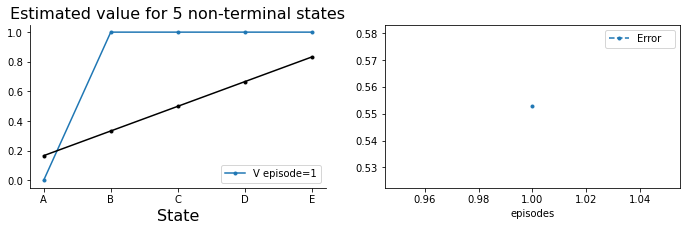

In [16]:
mc = MC1st(episodes=1, plotV=True, plotE=True).interact()

As you can see we have called 
MC = MC1st(MRP)
to make sure that we are dealing with latest MRP definition.

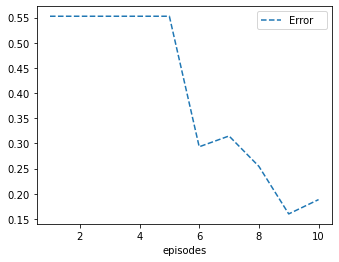

In [17]:
mc = MC1st(episodes=10, plotE=True).interact()

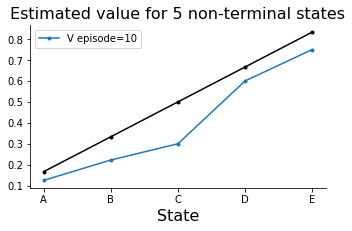

In [18]:
mc = MC1st(episodes=10, plotV=True).interact()

Ok one more thing, to avoid passing the value of plotE=True, plotV=True, animate=True, whenever we want to demo a prediction algorithm, we can create a dictionary and store these values in it and then pass the reference to the MC1st call, below we show how.

In [19]:
demoV = {'plotE':True, 'plotV':True, 'animate':True} # suitable for prediction

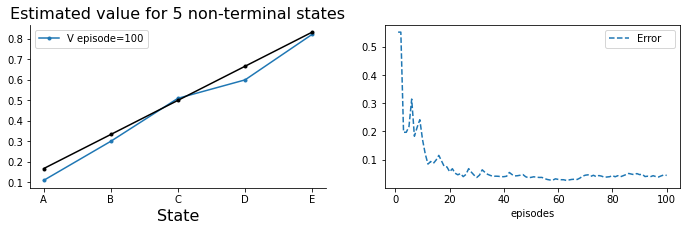

In [20]:
mc = MC1st(episodes=100, **demoV).interact()

In [21]:
mc.ep

99

In [22]:
mc.V

array([0.        , 0.10909091, 0.3       , 0.51      , 0.6       ,
       0.82258065, 0.        ])

## MDP environment for control

Let us now extend our MRP class to deal with control. We would need to deal with the Q action-value function instead of the value function V. Also lacking is a set of non-stationary policies that allows us to take advantage of the Q action-value function. Below we show this implementation. 

We also use a class factory to define our MDP class. Doing so will save us from redefining the class again when we amend our MRP class. We will need to amend the MRP when we change the state representation to use function approximation in the next unit.

The q0 is the initial set of values we might want to set up for all our Q estimates. We can also opt for completely random values for each action-value pair, we have left this out for simplicity of the coverage, but you can try it yourself.  ε is the percentage of time we want our agent to explore. 

The class defines a set of policy-related functions that revolve around the ε-greedy policy. We have implemented a simple, deterministic greedy policy that always chooses the first max Q action greedy_(). The main difference between greedy_() and εgreedy() for ε=0 is that the latter stochastically chooses between multiple *optimum* actions with the same action-value function. This is useful when we use exploration by optimistic initialisation since the greedy_() function can cause action starvation (a phenomenon where the action is never selected). Nevertheless, greedy_() is useful to test the optimality of a learned policy (once learning finishes) and is used within πisoptimal() function.

The πisoptimal() function returns whether the current policy is optimal by checking if the agent can reach the goal in a predefined number of steps stored in self.Tstar. The π() function returns the probability of taking a certain action under the ε-greedy policy. Finally, the render() function deals with rendering a policy.

Below we show a simple example of how choices will work when we use weights to choose an action according to its Q value.

In [23]:
Qs = np.array([10, 20, 20, 20])
τ = 10
exp = np.exp(Qs/τ)
choices(range(4), weights=exp/exp.sum(), k=1)[0]

3

In [24]:
np.where(Qs==Qs.max())[0]

array([1, 2, 3], dtype=int64)

In [25]:
a=4
maxAs = [1,2 ,3]
a in maxAs

False

In [26]:
choices([5,2,6])

[6]

In [27]:
def MDP(MRP=MRP):
    class MDP(MRP):
        def __init__(self, env=grid(), commit_ep=0, ε=.1, εmin=0.01, dε=1, εT=0, q0=0, Tstar=0, **kw): 

            super().__init__(env=env, **kw)
            # set up hyper parameters
            self.ε = ε 
            self.ε0 = ε  # store initial 
            self.dε = dε # for exp decay
            self.εT = εT # for lin decay
            self.εmin = εmin
            
            # override the policy to εgreedy to make control possible
            self.policy = self.εgreedy

            # initial Q values
            self.q0 = q0

            # which episode to commit changes
            self.commit_ep = commit_ep
            
            # number of steps for optimal policy
            self.Tstar = Tstar
            
        # set up the Q table
        def init_(self):
            super().init_() # initialises V
            self.Q = np.ones((self.env.nS,self.env.nA))*self.q0
        
        #------------------------------------- add some more policies types 🧠-------------------------------
        # useful for inheritance, gives us a vector of actions values
        def Q_(self, s=None, a=None):
            return self.Q[s] if s is not None else self.Q
        

        # returns a pure greedy action, **not to be used in learning**
        def greedy_(self, s):
            return np.argmax(self.Q_(s))
        
        # greedy stochastic MaxQ
        def greedy(self, s): 
            self.isamax = True
            # instead of return np.argmax(Q[s]) get all max actions and return one of the max actions randomly
            Qs = self.Q_(s)
            #print(Qs)
            if Qs.shape[0]==1: raise ValueError('something might be wrong number of actions ==1')
            return choices(np.where(Qs==Qs.max())[0])[0] # more efficient than choice
            #return choice(np.where(Qs==Qs.max())[0])

        # returns a greedy action most of the time
        def εgreedy(self, s):
            # there is pr=ε/nA that a max action is chosen but is not considerd max, we ignored it in favour of efficiency
            self.isamax = False 
            if self.dε < 1: self.ε = max(self.εmin, self.ε*self.dε)              # exponential decay
            if self.εT > 0: self.ε = max(self.εmin, self.ε0 - self.t_ / self.εT) # linear      decay
            
            return self.greedy(s) if rand() > self.ε else randint(0, self.env.nA)
    
        # returns the policy probabilities (of selecting a specific action)
        def π(self, sn,  a=None):
            ε, nA, Qsn = self.ε, self.env.nA, self.Q_(sn)
            π_ = Qsn*0 + ε/nA
            π_[Qsn.argmax()] += 1-ε
            return π_ if a is None else π_[a]

        # returns whether the current policy is optimal by checking if agent can reach the goal in self.Tstar
        def πisoptimal(self):
            s = self.env.reset()
            done = False
            for t in range(self.Tstar):
                s,_, done,_ = self.env.step(self.greedy_(s))
            return done

        #---------------------------------------visualise ✍️----------------------------------------
        # override the render function
        def render(self, rn=None, label='', **kw):
            if rn is None: rn=self.rn
            param = {'Q':self.Q_()} if 'Q' in self.underhood else {} # 'maxQ' or 'Q'
            self.env.render(**param, 
                            label=label+' reward=%d, t=%d, ep=%d'%(rn, self.t+1, self.ep+1), 
                            underhood=self.underhood, **kw)
    
    return MDP


You might have realised that we used a class factory for MDP. This is because we want our class to be flexible later to accommodate for changes in the MRP parent class. That is if we change the MRP class in later lessons we do not need to restate the MDP definition to inherit from the new MRP class, instead we just pass MDP(MRP) where MRP will be taken as the latest definition. This is will be appreciated in later lessons.

## First-visit MC control 

Now we extend this class to overload the offline function to offload it with our 1st-visit Monte Carlo method for control.

In [28]:
class MC1stControl(MDP()):
        
    def init(self):
        self.store = True
        self.ΣQ   = self.Q*0      # the sum of returns for all episodes
        self.ΣepQ = self.Q*0      # counts for numbers of times we add to the return  
    
    def offline(self): 
        #initialise the values
        Qs = self.Q*0
        epQ= self.Q*0
        
        # obtain the return for the latest episode
        Gt = 0
        for t in range(self.t, -1, -1):
            s = self.s[t]
            a = self.a[t]
            rn = self.r[t+1]
            
            Gt = self.γ*Gt + rn
            Qs[s,a] = Gt
            epQ[s,a] = 1

        # add the counts to the experience and obtain the average as per MC estimates
        self.ΣQ   += Qs
        self.ΣepQ += epQ
        ind = epQ>0 # avoid /0
        self.Q[ind] = self.ΣQ[ind]/self.ΣepQ[ind] 


### Applying MC on a control problem

Similar to what we did for prediction, we get help from a dictionary that stores a set of useful configurations that we use often. In the case of control, the most useful is plotting the number of steps the agent took to reach a terminal state in each episode or the sum of rewards the agent collected in each episode. Each one of these plots can be useful for certain tasks. Bear in mind that if the reward is given only for reaching the goal location or terminal state, the sum of the rewards plot would be a constant line that does not convey useful information. Below we show each.

In [29]:
demoT = {'plotT':True, 'visual':True, 'underhood':'maxQ'}                 # suitable for control
demoR = {'plotR':True, 'visual':True, 'underhood':'maxQ'}                 # suitable for control
demoTR= {'plotT':True, 'plotR':True, 'visual':True, 'underhood':'maxQ'}   # suitable for control
demoQ = demoT # alias

We can go a bit further and define a set of useful functions that we can utilise in all of our lessons which saves us from having to redefine the above dictionaries as follows.

In [30]:
def demo(what='V'):
    switch = {
        'V':    {'plotE':True, 'plotV':True, 'animate':True},                    # suitable for prediction
        'T':    {'plotT':True, 'visual':True, 'underhood':'maxQ'},               # suitable for control
        'R':    {'plotR':True, 'visual':True, 'underhood':'maxQ'},               # suitable for control
        'TR':   {'plotT':True, 'plotR':True, 'visual':True,'underhood':'maxQ'},  # suitable for control
        'Game': {'plotT':True, 'plotR':True, 'visual':True, 'animate':True}      # suitable for games
    }
    return switch.get(what,{})
def demoV(): return demo('V')
def demoT(): return demo('T')
def demoQ(): return demo('T')# alias
def demoR(): return demo('R')
def demoTR(): return demo('TR')
def demoGame(): return demo('Game')

Ok, back to our MC algorithm.
Unfortunately, applying the MC control algorithm with the default reward function will not yield a useful policy. This is because the explore-start condition is not satisfied (refer to section 5.4 of our book). In addition, averaging solutions may not perform well because they do not track a changing policy well for non-stationary problems (most of the control problems are non-stationary). To see this, uncomment the lines in the cell below and run it. (Note that we have set up the priorities of the actions in a way that will show this issue (right comes before left and down before up)

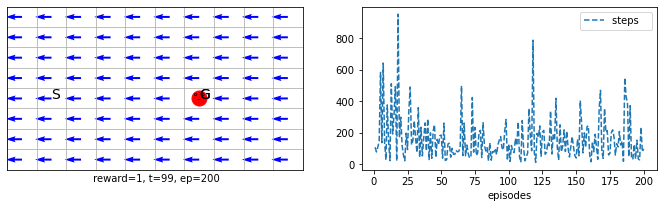

In [31]:
mc = MC1stControl(env=grid(), γ=1, episodes=200,  seed=10, **demoQ()).interact()

### The role of the discount factor $\gamma$ for delayed reward
**Important Note**
It is always the case that when we use a *delayed reward* (which is the default reward for our Grid class), the discount factor $\gamma$ **must not be set to 1**. This is because the sum of the discounted rewards of each visited state will be equal to the delayed reward itself, which will not give any particular advantage to follow a shorter path, yielding a useless policy. Therefore, we can solve this issue 
1. either by providing a discounted value for $\gamma$ that < 1.
1. or by changing the reward to have intermediate steps reward, which, when accumulated, will provide distinguished sums for the different paths and hence help distinguish the shortest path or the policy that will yield an optimal reward.

### Solution 1
Below we show how we can simply reduce $\gamma$ to solve this issue.

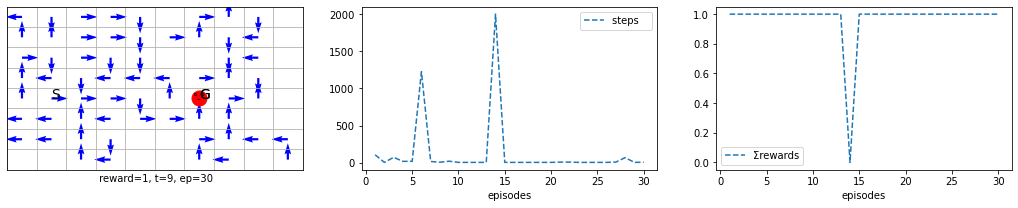

In [32]:
mc = MC1stControl(env=grid(), γ=.99, episodes=30, seed=10, **demoTR()).interact()

### Solution 2
Also we can compensate for the above issue, we would need to set up a reward function that allows the agent to quickly realise when it stuck in some not useful policy.

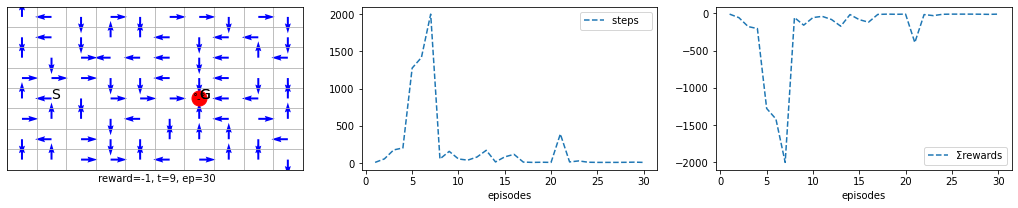

In [33]:
mcc = MC1stControl(env=grid(reward='reward_1'), episodes=30, seed=0, **demoTR()).interact()

Compare the above policy with the one produced by the DP solution in lesson 2. You will notice that the MC solution does not give a comprehensive solution from all states because we do not start from different cells. The starting position is fixed. The exploration nature of the policy allowed the agent to develop an *understanding* through its Q function of where it should head if it finds itself in a specific cell. The Markovian property is essential in guaranteeing that this can be safely assumed.

You might have noticed that although the task is very straightforward, the agent detoured a bit from the simplest straight path that leads to the goal. Bear in mind that we are adopting an εgreedy policy by default, which means that the agent will take some explorative actions 10% of the time. But this should not have prevented the maxQ policy from pointing towards the goal. This is because of the nature of MC itself and its sampling averages. The next section demonstrates how we can overcome this difficulty.

We can play with the exploration but that is needs lots of trail and is not straightforward.

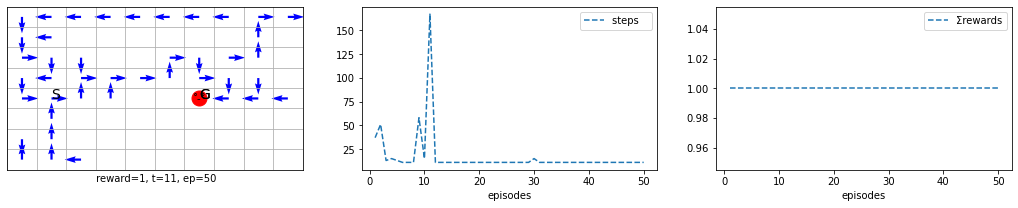

In [34]:
mc = MC1stControl(env=grid(), γ=.97, episodes=50, ε=.5, dε=.99, seed=20, **demoTR()).interact()

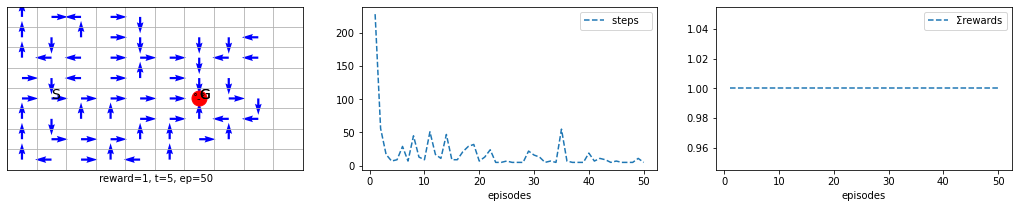

In [167]:
mc = MC1stControl(env=grid(), γ=.97, episodes=50, ε=.5, εT=3000, seed=20, **demoTR()).interact()

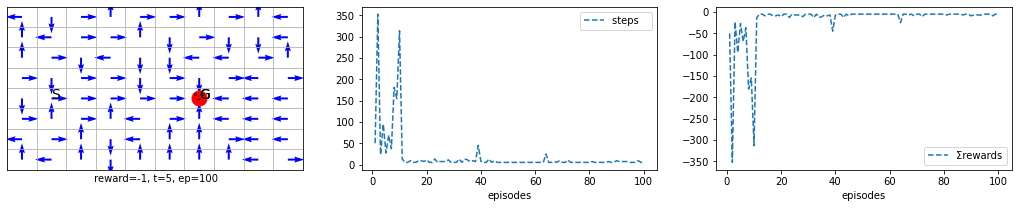

In [170]:
mcc = MC1stControl(env=grid(reward='reward_1'), γ=.97, episodes=100, ε=0.9, dε=.999, seed=20, **demoTR()).interact()

### Demos Related

Note how the arrows represent the policy change from one episode to another. We have turned off showing the agent's movements inside all but the last episode because it is usually unnecessary. If you want to see a specific episode, just set the 'episodes' variable to it, and you will be able to. For example, if you want to see what is happening in episode 3, set episodes=3 (to guarantee seeing exactly the same episode every time you repeat the experiment, you would need to fix the seed).

Please differentiate between seeing the arrows changing from one episode to another and when you see them changing inside an episode. Inside an episode, the arrow of a state changes only when the agent visits a state. The exception to this rule is when we use planning (or eligibility traces), where an arrow of a cell can change way after it has been visited. This is because we store those visits in these methods and reuse them in our updates. We will examine planning and eligibility traces in later lessons.

We can choose to plot and animate at the same time. Bear in mind that this will slow down the process a bit. 
If the learning is slow anyway, such as in Atari, then it makes sense to animate and plot as it will keep you informed about which episode your agent is in and how well it is doing so far!
It is better to keep the animation turned off for ordinary classical environments as those do not take time anyway.


**Important Notes Regarding Demos**
Notice how the visualisation behaves for demoGame() vs demoTR(), demoT() and demoR(). 

When we use demoTR(), demoT() or demoR(), the algorithm will train the agent silently without showing the plots and then at the last few episodes (as per view variable which is usually 1; meaning last episode), it shows a demo and then shows the performance plots. demoTR(), demoT() and demoR() are usually more efficient and take up less time.

On the other hand, when we use demoGame(), the algorithm will show the performance plots progress live from one episode to another. Then, in the final few episode (according to view), it shows a demo and the performance plots. During the demo, the plots disappear, and they reappear at the end. This helps keep our code as tidy and efficient as possible.

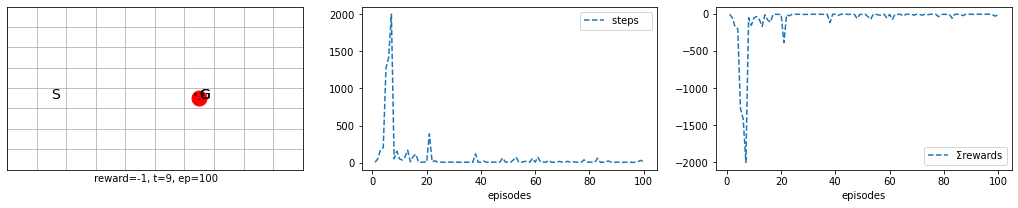

In [35]:
mcc = MC1stControl(env=grid(reward='reward_1'), episodes=100, seed=0, **demoGame()).interact()

### Plots without Demos
Let us see how to plot only
The most efficient way is just to turn off animate and set plotT or plotR to True.

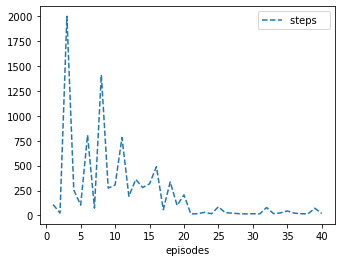

In [35]:
mcc = MC1stControl(env=grid(reward='reward_1'), episodes=40, seed=10, plotT=True, animate=False).interact()

we can also plot live as the algorithm is training

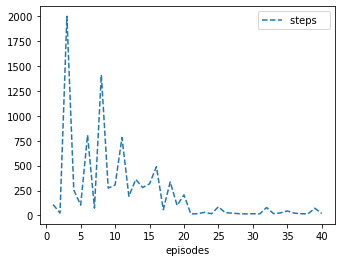

In [36]:
mcc = MC1stControl(env=grid(reward='reward_1'), episodes=40, seed=10, plotT=True, animate=True).interact()

### Demos without Training
We can also run without training, Unfortunately that means that we would have to loose the training traces of the last few episodes that we want to visualise and replace them with the latest performance after training. 

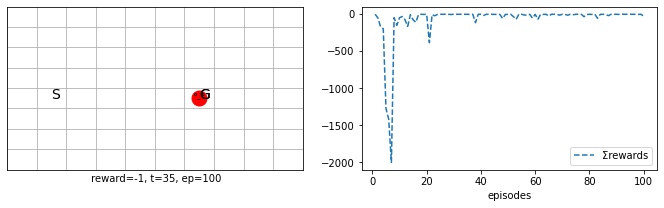

In [36]:

mcc.ep = mcc.ep - 5
mcc.plotT = False
mcc.visual = True
# mcc.underhood='maxQ' # uncomment to see also the policy
mcc.interact(train=False, **demoGame())


## Incremental constant-α MC: Every-visit MC Prediction

In [38]:
class MC(MRP):

    def init(self):
        self.store = True

    # ----------------------------- 🌘 offline, MC learning: end-of-episode learning ----------------------    
    def offline(self):
        # obtain the return for the latest episode
        Gt = 0
        for t in range(self.t, -1, -1):
            s = self.s[t]
            rn = self.r[t+1]
            
            Gt = self.γ*Gt + rn
            self.V[s] += self.α*(Gt - self.V[s])

This type of algorithmic design is more flexible and will be used in general in RL instead of the implementation that requires storing the sums or averages.

### Apply incremental MC on prediction problem

Let us try our new shiny prediction algorithm on the random walk problem.

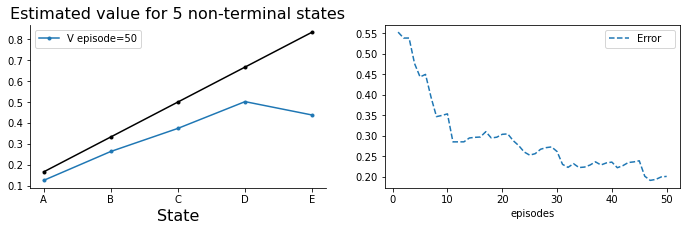

In [39]:
mc = MC( α=.02, episodes=50, **demoV()).interact()

Notice how jumpy the MC is.

## Incremental MCC: Every-visit MC Control

In [40]:
# note that the name has double C: we are dealing with MC+Control
class MCC(MDP()):

    def init(self):
        self.store = True

    # ---------------------------- 🌘 offline, MC learning: end-of-episode learning 🧑🏻‍🏫 -----------------------    
    def offline(self):  
        # obtain the return for the latest episode
        Gt = 0
        for t in range(self.t, -1, -1):
            s = self.s[t]
            a = self.a[t]
            rn = self.r[t+1]

            Gt = self.γ*Gt + rn
            self.Q[s,a] += self.α*(Gt - self.Q[s,a])

### Apply incremental MC on control problem

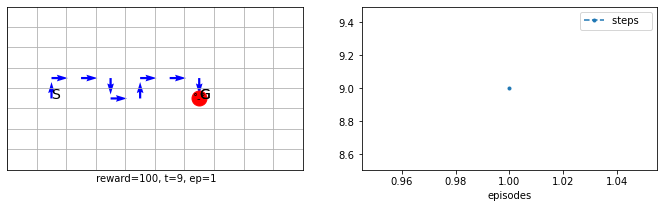

In [41]:
mcc = MCC(env=grid(reward='reward100'), α=.2, episodes=1, seed=0, **demoQ()).interact()

We can also pass the seed to the interact() function

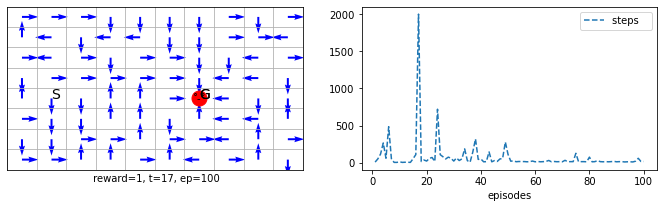

In [42]:
mcc = MCC(env=grid(reward='reward1'), α=.1, episodes=100,  **demoQ()).interact(seed=0)

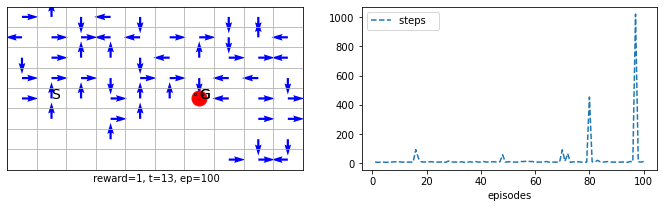

In [43]:
mcc = MCC(env=grid(), α=.1, episodes=100,  **demoQ()).interact(seed=0)

As we can see, although we solved the issue of tracking a non-stationary policy when we used a constant learning rate α, and we tried to use a reward function that gives immediate feedback to each step instead of a delayed reward, but still the performance is not as good as we wished for. This is due to our final issue, which is the action precedence that we set up to prefer left over right. If we change this precedence, it will help the agent to immediately find the goal, however, we set it up this way to make the problem more challenging. Consider changing this precedence to see the effect.

In [44]:
mcc.α

0.1

Let us animate and show progress at the same time, as we said earlier this will slow the learning due to animation overhead.

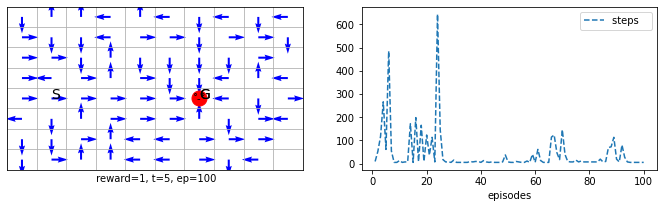

In [45]:
mcc = MCC(env=grid(reward='reward1'), α=.001, episodes=100, animate=True, **demoQ()).interact(seed=0)

We can also just visualise the last 2 episodes.

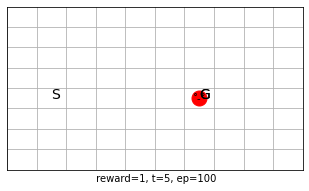

In [46]:
mcc = MCC(env=grid(reward='reward1'), α=.001, episodes=100, view=2, visual=True).interact(seed=0)

In [47]:
mcc.view

2

## REINFORCE: MC for Policy Gradient

So far, we have only seen how to estimate a value function to deduce a policy from this value function and then improve the policy by preferring a greedy action with a bit of exploration (as in ε-greedy policy). When we allow the agent to act according to this new policy, its value function might change, so we must re-estimate the value function. We go into iterations of this process until the policy and value function are both stable (converge). We also saw that we could integrate both operations seamlessly into one iteration, as in the value-iteration algorithm in Dynamic Programming. We can even do both stages in one *step* as in Q-learning or Sarsa, as we shall see in the next lesson. The policy improvement theorem and the Generalised Policy Iteration process guarantee all of this. The primary approach we took to achieve learning for an **action-value** method is to **minimise an error function** between our estimate of a value function and the actual value function. Since the real value function is unavailable, we replaced it with some samples (unbiased as in MC and biased as in TD that we will see later).

**Policy gradient** algorithms, on the other hand, attempt to **maximise an objective function** instead of minimising an error function. 
Can you think of a function that, if we maximise, will help us solve the RL problem...? pause for a moment and think.

As you might have guessed, the value function can be used as an objective function. The objective here is to change the policy to maximise the value function. 

Directly estimating the policy means we are not using a value function to express the policy as in the e-greedy. Instead, we are using the value function to learn the policy directly. So, our algorithm does not need to learn the value function explicitly; it can learn a set of parameters that will maximise the value function without knowing what the value function is. It will come as a consequence of learning a policy. In the same way that we did not need to learn a policy in the value-function approach, we learned a value function, and as a consequence of minimising the error, we can deduce a policy from the learned value function. This is the fundamental difference between value function approaches and policy gradient approaches.

Estimating the policy directly means we do not need to restrict the policy parameters to value function estimates and their ranges. The policy parameters that represent the preferences to select an action are free to take on any range of values as long as they comparatively form a cohesive policy that maximises the value function by dictating which action to choose in a specific state. This is a major advantage because the value function is strictly tied to the sum of rewards values, while a policy need not have this coupling. This will give us more freedom in using classification architectures when we use function approximation which excels in deducing the best action for a state, instead of using a regression architecture to regress a value function which is usually more prone to initial condition issues and are harder to train.

The best policy representation in a policy gradient method is the action selection softmax policy we came across in our last few lessons. This is a smooth function that, unlike ε-greedy, allows the changes in the probabilities to be continuous and integrates very well with policy gradient methods. One of the significant advantages of policy gradient methods (the policy is differentiable everywhere, unlike stepwise ε-greedy functions) is that it provides better guarantees of convergence than ε-greedy due to this smoothness (ε-greedy can change abruptly due to small changes in the action-value functions, while softmax just smoothly increases or decrease the probability of selecting ana action when its action-value function changes).

We start our coverage for policy gradient methods with an offline method; REINFORCE. REINFORCE is an algorithm that takes a *policy gradient* approach instead of an action-value function approach. The idea is simple, given that an episode provides a sample of returns for the visited states, at the end of an episode, we will take the values of the states and use them to guide our search to find the optimal policy that maximises the value function. 

**Note** that policy gradient sections in this lesson, and the next are based on chapter 13 of our book. They can be read as they appear in the notebook or delayed until the end of lesson 9.


## Policy Gradient Class
The softmax is the default policy selection procedure for Policy Gradient methods. $\tau$ acts like an exploration factor (more on that later) and we need to one-hot encoding for the actions.

In [48]:
Ia = np.eye(4)
print(Ia)
print(Ia[1].shape)
print(Ia[1])

[[1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]]
(4,)
[0. 1. 0. 0.]


In [49]:
pi = np.zeros(4)
pi[1]=1
print(pi)

[0. 1. 0. 0.]


In [50]:
def PG(MDP=MDP(MRP)):
    class PG(MDP):
        def __init__(self, τ=1, τmin=.1, dτ=1, Tτ=0, **kw):
            super().__init__(**kw)
            # set up hyper parameters
            self.τ = τ
            self.τ0 = τ
            self.dτ = dτ
            self.Tτ = Tτ
            self.τmin = τmin

            # softmax is the default policy selection procedure for Policy Gradient methods
            self.policy = self.τsoftmax

        #------------------------------------- add some more policies types 🧠-------------------------------

        # returns a softmax action
        def τsoftmax(self, s):
            Qs = self.Q_(s)
            
            if self.dτ < 1: self.τ = max(self.τmin, self.τ*self.dτ)              # exponential decay
            if self.Tτ > 0: self.τ = max(self.τmin, self.τ0 - self.t_ / self.Tτ) # linear      decay
                
            exp = np.exp(Qs/self.τ)
            maxAs = np.where(Qs==Qs.max())[0]
            #a = choice(self.env.nA, 1, p=exp/exp.sum())[0]
            a = choices(range(self.env.nA), weights=exp/exp.sum(), k=1)[0]
            self.isamax = a in maxAs
            return a

        # overriding π() in parent class MDP: 
        # in MDP π() returns probabilities according to a εgreedy,
        # in PG  π() returns probabilities accroding to a τsoftmax, while
        def π(self, s, a=None):
            Qs = self.Q_(s)
            exp = np.exp(Qs/self.τ)
            return exp/exp.sum() if a is None else (exp/exp.sum())[a]
        
    return PG

Ok, so now we are ready to define our REINFORCE algorithm. This algorithm and other policy gradient algorithm always have two updates, one for V and one for Q. In other words, the action-value function update will be guided by the state-value update. We usually call the first update deals that with V, the critic and the second update that deals with Q the actor.

In [51]:
class REINFORCE(PG()):
    
    def init(self):
        self.store = True

    # -------------------- 🌘 offline, REINFORCE: MC for policy gradient methdos ----------------------
    def offline(self):
        π, γ, α, τ = self.π, self.γ, self.α, self.τ
        # obtain the return for the latest episode
        Gt = 0
        γt = γ**self.t                   # efficient way to calculate powers of γ backwards
        for t in range(self.t, -1, -1): # reversed to make it easie to calculate Gt
            s = self.s[t]
            a = self.a[t]
            rn = self.r[t+1]
            
            Gt = γ*Gt + rn
            δ = Gt - self.V[s]
            
            self.V[s]   += α*δ
            self.Q[s,a] += α*δ*(1 - π(s,a))*γt/τ
            γt /= γ


## The Role of Discount Factor $\gamma$ in Policy Gradient Methods
$\gamma$ seems to play a more important role in policy gradient methods than in action-value methods.
The next few examples show how $\gamma$ can make the difference between convergence and divergence.
The main issue is, as usual, whether the *reward* is delayed or there is an intermediate reward. If the reward is delayed, we would need to assign $\gamma$ values that are < 1 so that the sum of the rewards is discounted, which helps the agent differentiate between longer and shorter paths solution. However, $\gamma$ also plays a role in convergence when the reward is not delayed. It complements the role that $\tau$ plays in the SoftMax policy. Therefore, instead of tuning $\tau$ we can reduce $\gamma$ specifically when the goal reward is 0, and the intermediate reward is -1 (reward_0) function. Let us see some examples:

The below shows that REINFORCE diverges when τ=1, γ=1, for (reward='reward_1').

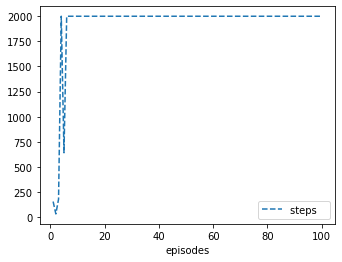

In [52]:
reinforce = REINFORCE(env=grid(reward='reward0'), α=.1, τ=1, γ=1, episodes=100, seed=10, plotT=True).interact()

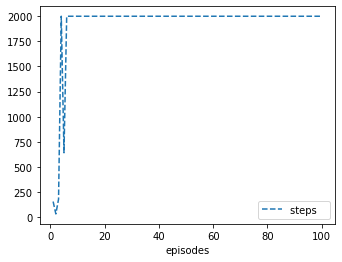

In [53]:
reinforce = REINFORCE(env=grid(reward='reward_1'), α=.1, τ=1, γ=1, episodes=100, seed=10, plotT=True).interact()

Below we increase the value of $\tau$ to deal with this issue of diveregnce.

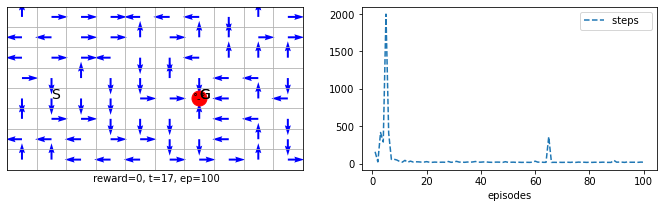

In [54]:
reinforce = REINFORCE(env=grid(reward='reward0'), α=.1, τ=2, γ=1, episodes=100, seed=10 , **demoQ()).interact()

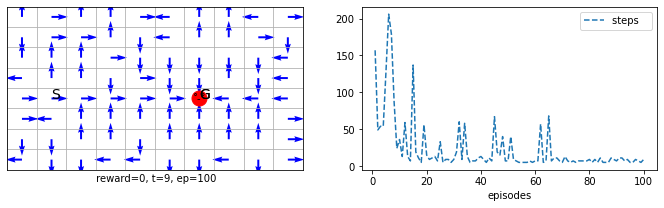

In [55]:
reinforce = REINFORCE(env=grid(reward='reward0'), α=.1, τ=3, γ=1, episodes=100, seed=10 , **demoQ()).interact()

In [56]:
s=31
print(reinforce.Q[s])
print(reinforce.π(s))

[-9.39998085  5.37572334 -6.32250724 -6.20289915]
[0.00692454 0.95365926 0.01931528 0.02010092]


As we can see REINFORCE converged when we increase $\tau$ which helped the values in SoftMax to become appropriatly smaller to help the algorithm to converge.

Let us now decrease the value of $\gamma<1$ and keep $\tau=1$

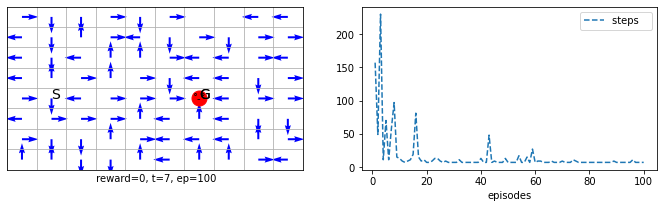

In [57]:
reinforce = REINFORCE(env=grid(reward='reward0'), α=.1, τ=1, γ=.98, episodes=100, seed=10, **demoQ()).interact()

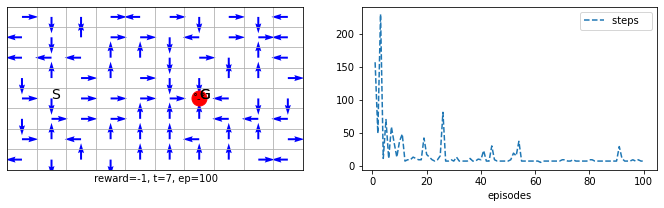

In [58]:
reinforce = REINFORCE(env=grid(reward='reward_1'), α=.1, τ=1, γ=.98, episodes=100, seed=10, **demoQ()).interact()

As we can see decreasing $\gamma$ helped REINFORCE immensely to converge. Although the reward that we used is 'reward_1' which is not delayed, but discounting the return helped the value function to be more meaningful for the problem in hand which helped in turn the policy to be more appropriate for the problem in hand.  

Let us now increase $\tau$ and keep $\gamma<1$ this will reveal another role for $\tau$.

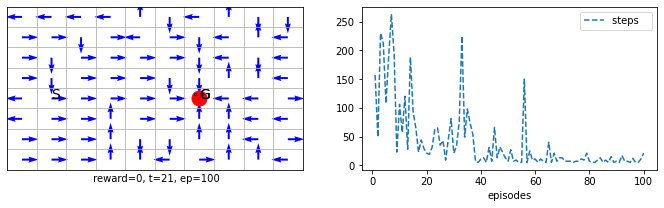

In [59]:
reinforce = REINFORCE(env=grid(reward='reward0'), α=.1, τ=2, γ=.98, episodes=100, seed=10, **demoQ()).interact()

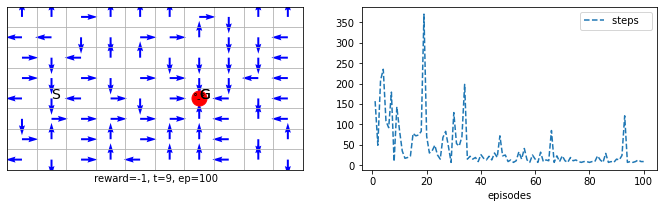

In [60]:
reinforce = REINFORCE(env=grid(reward='reward_1'), α=.1, τ=2, γ=.98, episodes=100, seed=10, **demoQ()).interact()

As we can see increasing $\tau$ while using $\gamma <1$ did not help. We will mostly therefore use $\gamma <1$ for our policy gradient methods.  

## Delayed Reward and REINFORCE
Let us now look at a delayed reward

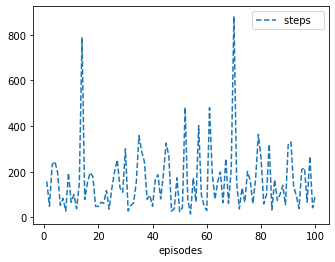

In [61]:
reinforce = REINFORCE(env=grid(), α=.1, τ=1, γ=1, episodes=100, seed=10, plotT=True).interact()

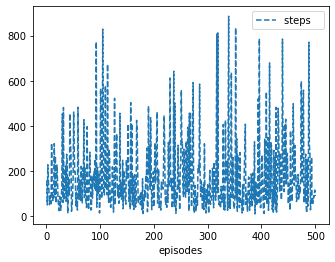

In [62]:
reinforce = REINFORCE(env=grid(), α=.1, τ=5, γ=1, episodes=500, seed=10, plotT=True).interact()

Note that whether we increase or decrease $\tau$ her, it will not help REINFORCE to converge since the value function that the algorithmm is learning is not appropriate when $\gamma=1$.

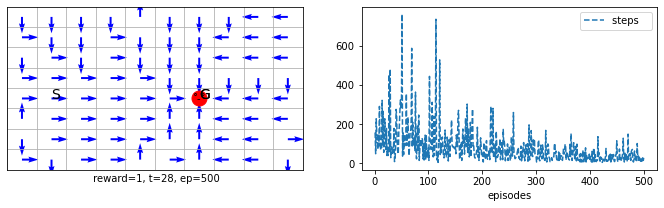

In [63]:
reinforce = REINFORCE(env=grid(), α=.1, τ=1, γ=.98, episodes=500, seed=10, **demoQ()).interact()

As we can see exploration is actually good, so let us decrease this exploration and see if that helps to reach faster convergence given that the environment is rather simple.

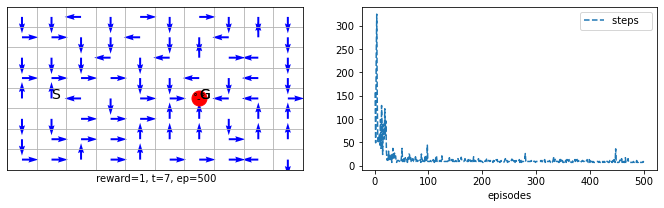

In [64]:
reinforce = REINFORCE(env=grid(), α=.1, τ=.2, γ=.98, episodes=500, seed=10, **demoQ()).interact()

Note how the algorithm converged faster but to sub-optimal solution.

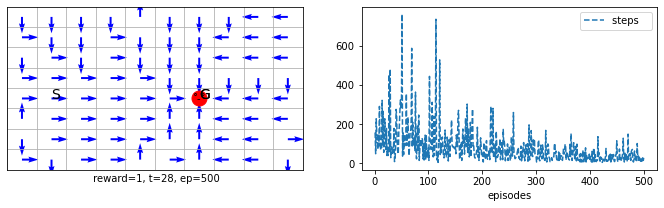

In [65]:
reinforce = REINFORCE(env=grid(), α=.1, τ=1, γ=.98, episodes=500, seed=10, **demoQ()).interact()

Note how exploration lead to a fully covered environment but to a slower convergence.

## Conclusion
In this lesson, we studied the properties of Monte Carlo algorithms for prediction and control. We started by covering a basic first visit MC method that averages the returns similar to what we did in lesson 1, this time for the associative problem (i.e., when we have states that we select specific actions for, un-associated problems do not have states and have been studied in lesson 1). We have then created an incremental MC algorithm that allows us to average the returns in a step-by-step manner. To that end, we have developed an essential MRP class that will carry the step-by-step and episode-by-episode interaction with an MRP environment, and then we added a useful set of visualisation routines. We have further inherited the MRP class in an MDP class that defines policies that depend on the Q function to obtain a suitable policy for an agent (i.e., control).
We noted that MC needed to wait until the episode was finished to carry out updates. In the next unit, we will study full online algorithms that mitigate this shortcoming of MC with the cost of bootstrapping. We will be using the MRP and MDP classes that we developed here.


# Unit's conclusion
This lesson concludes our unit where we have studied important formulation of RL all of which assumed that we use a table representation for our state space. In the next unit, we will study other offline and fully online RL algorithms that use bootstrapping. Additionally, we will study planning algorithms and then use function approximation instead of a table to represent the state space that can be continuous and infinite.


## Your turn
1. Change the probabilities of the actions in the stationary policy of an RMP class, use this policy in a random walk process and see the effect on the results.
1. Alter the MDP class to include a softmax policy, use this policy in a maze environment, instead of the e-greedy, and see the effect on the results.
1. There might be some potential for saving compute time if we check if the maxQ is unique, try to alter the greedy policy and observe if this potential can be realised.
1. Create a new class MCsoft algorithm that inherent from PG. This new class would have access to a SoftMax policy which is its default policy. Now apply it on the grid() and see the result.